In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb


# Parameters:
ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [3.9, 1.6, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.8, 0.6, 1.73, -0.6, 1.5708]]
                       )

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
RADIUS_MARGIN = 20.0 # In feature map



In [2]:
# Map anchors to image:
def map_to_img(value: float, pillar_size: tuple, min_value: float):
    mapped_value = (value - min_value) // pillar_size[0] # Floored division
    assert mapped_value >= 0.0
    return mapped_value

mapped_anchors = ANCHORS.detach().clone()

for anchor in mapped_anchors: # Overrides anchors height, width with mapped length and width
  anchor[0] = map_to_img(value=anchor[0], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since length is already a delta
  anchor[1] = map_to_img(value=anchor[1], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since width is already a delta

Create the random image for the test of the algorithm:

In [3]:
# Define the dimensions of the image
H = 500  # Height
W = 440  # Width

# Generate a random tensor of shape (H*W, 3) for a color image (3 channels)
random_tensor = torch.randn(H * W, 3)

# Reshape the tensor to match the image dimensions (H, W, C)
random_image = random_tensor.reshape(H, W, 3)

# Ensure the values are in the [0, 1] range (assuming you want a [0, 1] normalized image)
random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())
random_image = random_image.permute(2, 0, 1)
batched_random_image = random_image.unsqueeze(0) # Add batch size dim

In [27]:
# Create 2D bounding box Class:
class Box2D():
    def __init__(self, x_lims: tuple, y_lims: tuple, x_anchor: float, y_anchor: float, height: float, width: float):
        super().__init__()    
        self.x_anchor = x_anchor
        self.y_anchor = y_anchor
        self.height = height
        self.width = width
        self.x_max = self.x_anchor + self.width
        self.y_max = self.y_anchor + self.height
        self.x_lims = x_lims
        self.y_lims = y_lims



    def create_marker(self, color='r'):
        return(patches.Rectangle((self.x_anchor, self.y_anchor), width=self.width, 
                height=self.height, linewidth=2, edgecolor=color, facecolor='none'))
    

    def create_ROI(self, margin: float): 
      '''Returns a Box2D type with ROI'''
      ROI_box = copy.copy(self)
      ROI_box.x_anchor = self.x_anchor - margin
      ROI_box.y_anchor = self.y_anchor - margin
      ROI_box.height = self.height + 2*margin
      ROI_box.width = self.width + 2*margin

      # Clamp if ROI is out of the feature_map before returning:
      if (ROI_box.x_anchor < self.x_lims[0]): 
        ROI_box.x_anchor = self.x_lims[0]
      elif (ROI_box.x_anchor + ROI_box.width > self.x_lims[1]):
        ROI_box.x_anchor = self.x_lims[1]
      
      if (ROI_box.y_anchor < self.y_lims[0]):
        ROI_box.y_anchor = self.y_lims[0]
      elif (ROI_box.y_anchor + ROI_box.height > self.y_lims[1]):
        ROI_box.y_anchor = self.y_lims[1]

      return ROI_box
    

# TODO: Create anchors class:
class Anchor():
    def __init__(self, width, height, rotations=0.0):
        super().__init__()  
          
        self.width = width
        self.height = height

    def create_anchor_grid(self, feature_map, num_anchors_x, num_anchors_y): 

        '''In: feature map (bs, C, H, W)
            Returns: (grid_x, grid_y): ()
        '''

        self.grid_x = torch.linspace(0, feature_map.size()[-1], num_anchors_x) 
        self.grid_y = torch.linspace(0, feature_map.size()[-2], num_anchors_y) 
    
    def get_ROI_indices(self, feature_map, ROIs_list):

        '''In: feature_map, (bs, C, H, W),
            ROIs_list: list(Box2D)
            Out: {ROI #, list((idx_x, idx_y))}
        '''

        ROIs_indices = {}
        for ROI in ROIs_list:
          
            # TODO: Find tuple indices for min and max cordinate

            # Find the indices in grid_x and grid_y for the given (x_min, y_min) point of anchor:
            idx_x_min = int(torch.searchsorted(self.grid_x, ROI.x_anchor, right=True))
            idx_y_min = int(torch.searchsorted(self.grid_y, ROI.y_anchor, right=True))

            idx_x_max = int(torch.searchsorted(self.grid_x, ROI.x_max, right=True))
            idx_y_max = int(torch.searchsorted(self.grid_y, ROI.y_max, right=True))
            ROIs_indices[ROI] = [(idx_x_min, idx_y_min), (idx_x_max, idx_y_max)] #torch.tensor([idx_x_min, idx_y_min, idx_x_max, idx_y_max])
        
        return ROIs_indices 


        
# Define the IoU function
def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x_anchor, box2.x_anchor)
    y_top = max(box1.y_anchor, box2.y_anchor)
    x_right = min(box1.x_anchor + box1.width, box2.x_anchor + box2.width)
    y_bottom = min(box1.y_anchor + box1.height, box2.y_anchor + box2.height)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = box1.width * box1.height
    box2_area = box2.width * box2.height

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

            



IoU is 0.0 at (8, 4)
IoU is 0.0 at (8, 5)
IoU is 0.0 at (8, 6)
IoU is 0.04222052916884422 at (9, 4)
IoU is 0.04222052916884422 at (9, 5)
IoU is 0.0 at (9, 6)
IoU is 0.23999999463558197 at (10, 4)
IoU is 0.23999999463558197 at (10, 5)
IoU is 0.0 at (10, 6)
IoU is 0.16827332973480225 at (11, 4)
IoU is 0.16827332973480225 at (11, 5)
IoU is 0.0 at (11, 6)
IoU is 0.0 at (18, 8)
IoU is 0.0 at (18, 9)
IoU is 0.10256423056125641 at (19, 8)
IoU is 0.01976286806166172 at (19, 9)
IoU is 0.2666666805744171 at (20, 8)
IoU is 0.0458715595304966 at (20, 9)
IoU is 0.2666666805744171 at (21, 8)
IoU is 0.0458715595304966 at (21, 9)
IoU is 0.11459773033857346 at (22, 8)
IoU is 0.021888714283704758 at (22, 9)


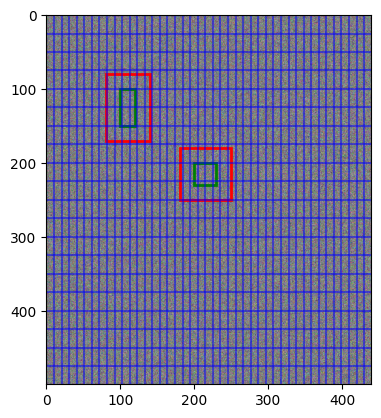

In [32]:

# Create a figure and axis for displaying the image
fig, ax = plt.subplots() # TODO: Move to the bottom


# Create ground truth bounding box coordinates and add rectangles to the image
gt_boxes = [Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=100, y_anchor=100, height=50, width=20), 
  Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=200, y_anchor=200, height=30, width=30)]
markers = []

roi_boxes = []

# Define ROIs and add marker for visualization:
for box in gt_boxes:
  roi_box = box.create_ROI(margin=RADIUS_MARGIN)
  roi_boxes.append(roi_box)
  ax.add_patch(roi_box.create_marker())
  ax.add_patch(box.create_marker(color='g'))

# Generate anchors with Anchor class:
anchors_list = []
anchor1 = Anchor(width=mapped_anchors[0][1], height=mapped_anchors[0][0]) #(width, height, rotations)


# TODO: Add more anchors
anchors_list.append(anchor1)


# Iterate over anchors, create grid and get mask indices

for anchor in anchors_list:
  # Get number of anchors that fit along width and height of image:
  num_anchors_x = int(torch.round(batched_random_image.size()[-1] / anchor.width)) 
  num_anchors_y = int(torch.round(batched_random_image.size()[-2] / anchor.height)) 

  anchor.create_anchor_grid(batched_random_image, num_anchors_x, num_anchors_y) 

  ROI_dict = anchor.get_ROI_indices(batched_random_image, roi_boxes) 

  for n_target, ROI in enumerate(ROI_dict):
    iou = 0.0
    gt_target = gt_boxes[n_target]
    lower_x_idx, lower_y_idx = ROI_dict[ROI][0][0], ROI_dict[ROI][0][1]
    upper_x_idx, upper_y_idx = ROI_dict[ROI][1][0], ROI_dict[ROI][1][1]

    found_target = False # breaker of feature_map scan iterator
    for i in range(lower_x_idx, upper_x_idx):
      if found_target:
        break

      for j in range(lower_y_idx, upper_y_idx):
        #try: # HACK
        anchor_box = Box2D( # Class should be declared before calling this ibject
          x_lims=(0.0, batched_random_image.size()[-1]), y_lims=(0.0, batched_random_image.size()[-2]),
          x_anchor=anchor.grid_x[i], y_anchor=anchor.grid_y[j], height=anchor.height, width=anchor.width)

          if iou < calculate_iou(anchor_box, gt_target):
            best_target = (i, j)
            if iou >= 0.5:
              found_target = True
              break # Break 2 for loops
    # TODO: 
    


        #print(f'IoU is {iou} at {(i,j)}')



  
for x in anchor1.grid_x: #FIXME: Hardcoded anchor
    ax.axvline(x=x, color='b', alpha=0.5)

for y in anchor1.grid_y: # FIXME: Hardcoded anchor
    ax.axhline(y=y, color='b', alpha=0.5)


# Display the image using imshow
ax.imshow(batched_random_image[0].permute(1, 2, 0)) # Plot batched_image here





In [26]:
ROI_dict

{<__main__.Box2D at 0x7f0626deeb20>: [(8, 4), (12, 7)],
 <__main__.Box2D at 0x7f0626f01bb0>: [(18, 8), (23, 10)]}

In [25]:
anchor1.grid_y

tensor([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.,
        300., 325., 350., 375., 400., 425., 450., 475., 500.])

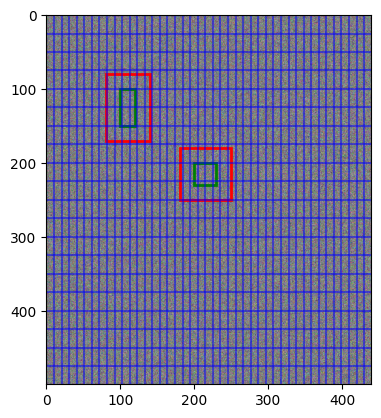

In [14]:
'''WARNING: CODE MODIFIED ABOVE'''

# Create a figure and axis for displaying the image
fig, ax = plt.subplots() # TODO: Move to the bottom


# Create ground truth bounding box coordinates and add rectangles to the image
gt_boxes = [Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=100, y_anchor=100, height=50, width=20), 
  Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=200, y_anchor=200, height=30, width=30)]
markers = []

roi_boxes = []

for box in gt_boxes:
  ax.add_patch(box.create_marker(color='g'))
  roi_box = box.create_ROI(margin=RADIUS_MARGIN)
  roi_boxes.append(roi_box)
  ax.add_patch(roi_box.create_marker())
  


# Create grid based on anchors:
num_anchors_x = int(torch.round(batched_random_image.size()[-1] / mapped_anchors[0][1])) # Taking width as x
num_anchors_y = int(torch.round(batched_random_image.size()[-2] / mapped_anchors[0][0])) # Taking height as y

# Create a linspace given the anchor size and grid based on the x-y linspaces:
grid_x = torch.linspace(0, batched_random_image.size()[-1], num_anchors_x) # From width to account for 0
grid_y = torch.linspace(0, batched_random_image.size()[-2], num_anchors_y) # From length to account for 0

for x in grid_x:
    ax.axvline(x=x, color='b', alpha=0.5)

for y in grid_y:
    ax.axhline(y=y, color='b', alpha=0.5)


# Display the image using imshow
ax.imshow(batched_random_image[0].permute(1, 2, 0)) # Plot batched_image here

80.0

In [19]:
# Define the IoU function
def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x_anchor, box2.x_anchor)
    y_top = max(box1.y_anchor, box2.y_anchor)
    x_right = min(box1.x_anchor + box1.width, box2.x_anchor + box2.width)
    y_bottom = min(box1.y_anchor + box1.height, box2.y_anchor + box2.height)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = box1.width * box1.height
    box2_area = box2.width * box2.height

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

# Create a list to hold grid cells within the ROI
grid_cells_within_roi = []

# Initialize a dictionary to hold the best anchor for each ground truth box
best_anchors_per_gt_box = {k: (None, 0) for k in range(len(gt_boxes))} # Dictionary {gt_box, (i,j,IoU)} highest

for i in range(len(grid_x) - 1):
    for j in range(len(grid_y) - 1):
        for k in range(len(roi_boxes)): 
            # TODO: Iterate also over number of anchors:
            anchor = Box2D()
            iou = calculate_iou(gt_boxes[k], )
            # Check if current cell is within any of the ROIs:
            '''cond1 = grid_x[i] > roi_boxes[k].x_anchor
            cond2 = grid_x[i] <= roi_boxes[k].x_anchor + roi_boxes[k].width
            cond3 = grid_y[j] > roi_boxes[k].y_anchor
            cond4 = grid_y[j] <= roi_boxes[k].y_anchor + roi_boxes[k].width
            if (cond1 and cond2 and cond3 and cond4):'''
                # TODO: Calculate IoU:


                # Append index:
                # grid_cells_within_roi.append((k,i,j)) # (roi_number, grid_x, grid_y)



                







# grid_cells_within_roi now contains the indices of the grid cells that are within the ROI
grid_cells_within_roi

[(8, 4),
 (8, 5),
 (9, 4),
 (9, 5),
 (10, 4),
 (10, 5),
 (11, 4),
 (11, 5),
 (12, 4),
 (12, 5),
 (13, 4),
 (13, 5),
 (18, 8),
 (18, 9),
 (18, 10),
 (19, 8),
 (19, 9),
 (19, 10),
 (20, 8),
 (20, 9),
 (20, 10),
 (21, 8),
 (21, 9),
 (21, 10),
 (22, 8),
 (22, 9),
 (22, 10),
 (23, 8),
 (23, 9),
 (23, 10),
 (24, 8),
 (24, 9),
 (24, 10)]

In [9]:
num_anchors_y

21

In [16]:
'''# Iterate over the grid lines
for i in range(len(grid_x) - 1):
    for j in range(len(grid_y) - 1):
        # Define the current grid cell
        cell = Box2D(x_lims=(0, W), y_lims=(0, H), 
                     x_anchor=grid_x[i].item(), y_anchor=grid_y[j].item(),
                     height=grid_y[j+1].item() - grid_y[j].item(), 
                     width=grid_x[i+1].item() - grid_x[i].item())

        # Check for each ROI box
        for roi_box in roi_boxes:


            if (iou < calculate_iou(cell, roi_box)):
                iou = calculate_iou(cell, roi_box)
                print(iou)

            # If IoU is above a threshold, consider the cell as within the ROI
            if iou > 0.5:  # Assuming a threshold of 0.5
                grid_cells_within_roi.append((i, j))'''

44